# RWTH Hack Mining 

## Track Drive Condition Monitoring of Mining Excavators (Komatsu)

## Overview: 

It is crucial to know the wear status of mining excavator track drives, because that helps to avoid costly unplanned downtime. To improve the current situation of risky and time-consuming manual geometric measurements, a concept of an automatic wear monitoring has been developed, that aims for detecting the wear during regular operation. As a proof of concept, a few hundred events were measured on a 550t-excavator and manually analyzed. Depending on the operating conditions, evaluation of different physical effects visible in sensor data allows conclusions to the current wear of the track drive. The task is to design an automatic algorithm to estimates the wear by evaluating the course of signals. To achieve that, toolboxes from Matlab (Signal Processing, Neural Network, Statistical) are to be applied. The outcome of the approaches should be validated by the manual evaluation results. To get you on track, an overview of the physics, videos and prepared sensor data will be provided. Take up the challenge and help make mining safer & smarter. Everyone, in particular students from engineering and computer science, is welcome. 


### 1. Import Relavent Libraries

In [159]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from scipy.ndimage import gaussian_filter1d
from scipy.signal import argrelextrema
from scipy.signal import find_peaks

### 2.  Data Pre Processing
#### 2.1 Import Data using Pandas

note: change the file path on your system

In [11]:
#get the data overview
data_path = '/Users/karenlee/Documents/VS_code/Hackkthon/data/Track_wear_m06_spot_turn.xlsx'
df_raw = pd.read_excel(data_path , engine = 'openpyxl') 
df_raw.head()

,Zeit -,n_sprocket_left - U/min,x_sprocket_left - mm,torque_travel_left - Nm,torque_travel_right - Nm,p_track_tension_left - bar,p_track_tension_right - bar
0,0.000000,0.000034,0.000000,1.321088,0.250282,39.281631,52.370979
1,0.000833,0.000034,0.000003,1.382598,0.224518,39.274406,52.369591
2,0.001667,0.000034,0.000005,1.266326,0.267108,39.260303,52.369404
3,0.002500,0.000034,0.000008,1.197580,0.344828,39.264931,52.369606
4,0.003333,0.000034,0.000011,1.277175,0.299051,39.273117,52.369202


#### 2.2 Plot Data 

**2.2.1 Torque and RPM Separately**

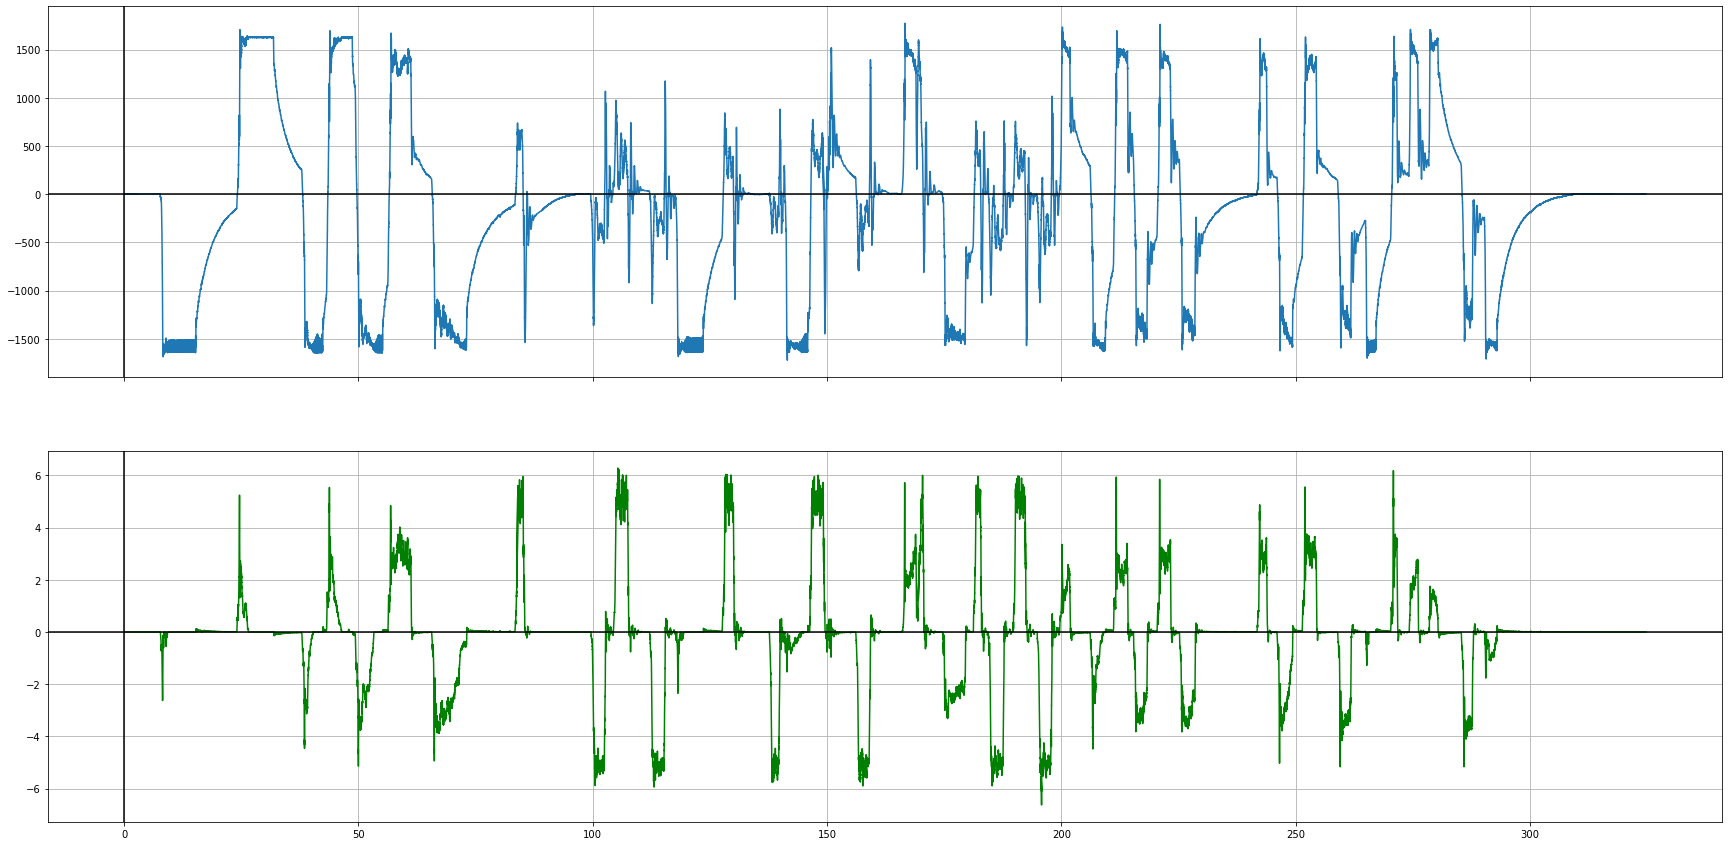

In [12]:
rpm_raw = df_raw["n_sprocket_left - U/min"]
torque_raw = df_raw["torque_travel_left - Nm"]
time = df_raw["Zeit - "]
fig, ax = plt.subplots(2,1, figsize = (30,15), sharex=True)
ax[0].plot(time, torque_raw )
ax[0].grid(True, which='both')
ax[0].axhline(y=0, color='k')
ax[0].axvline(x=0, color='k')

ax[1].plot(time, rpm_raw , 'g')
ax[1].grid(True, which='both')
ax[1].axhline(y=0, color='k')
ax[1].axvline(x=0, color='k')

**2.2.2 Plot Data - Torque and RPM together after data normalization**

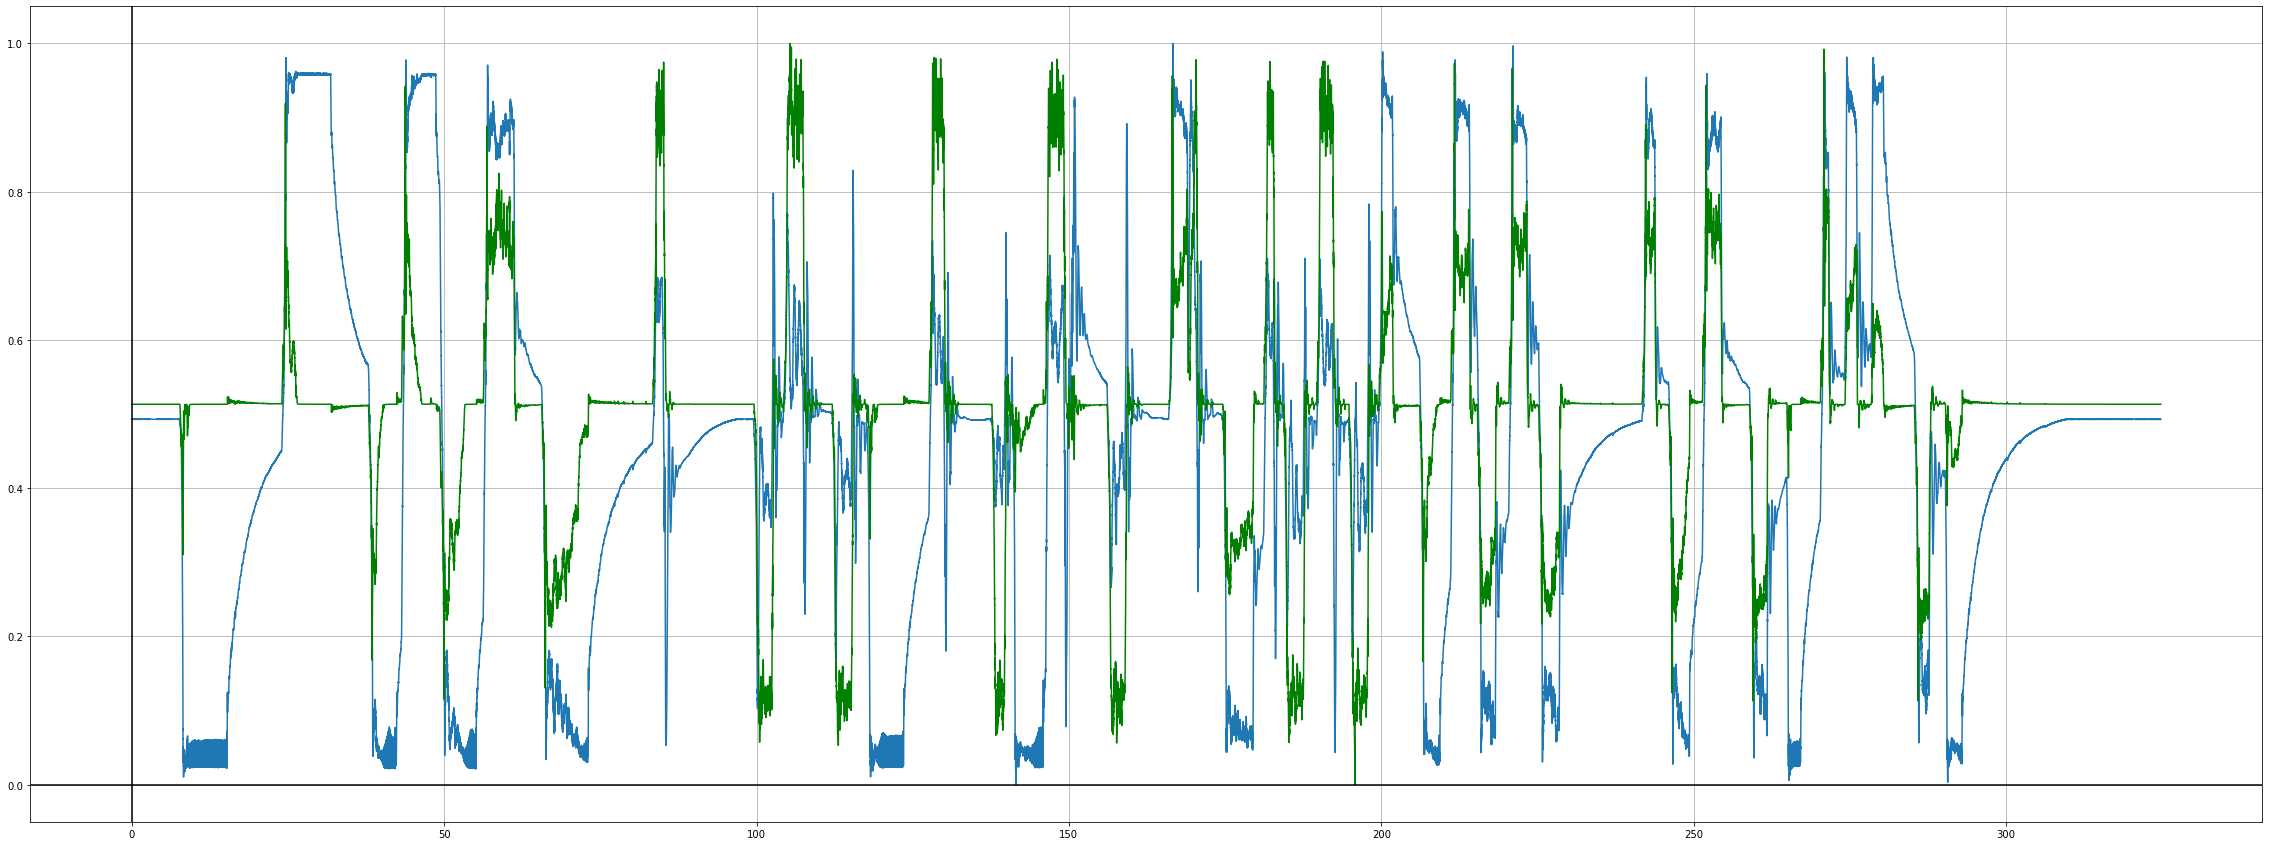

In [13]:

torque_raw_norm = (torque_raw-torque_raw.min())/(torque_raw.max()-torque_raw.min())
rpm_raw_norm = (rpm_raw-rpm_raw.min())/(rpm_raw.max()-rpm_raw.min())

fig, ax = plt.subplots(1,1, figsize = (40,15))
ax.plot(time, torque_raw_norm )
ax.plot(time, rpm_raw_norm , 'g' )
ax.grid(True, which='both')
ax.axhline(y=0, color='k')
ax.axvline(x=0, color='k')


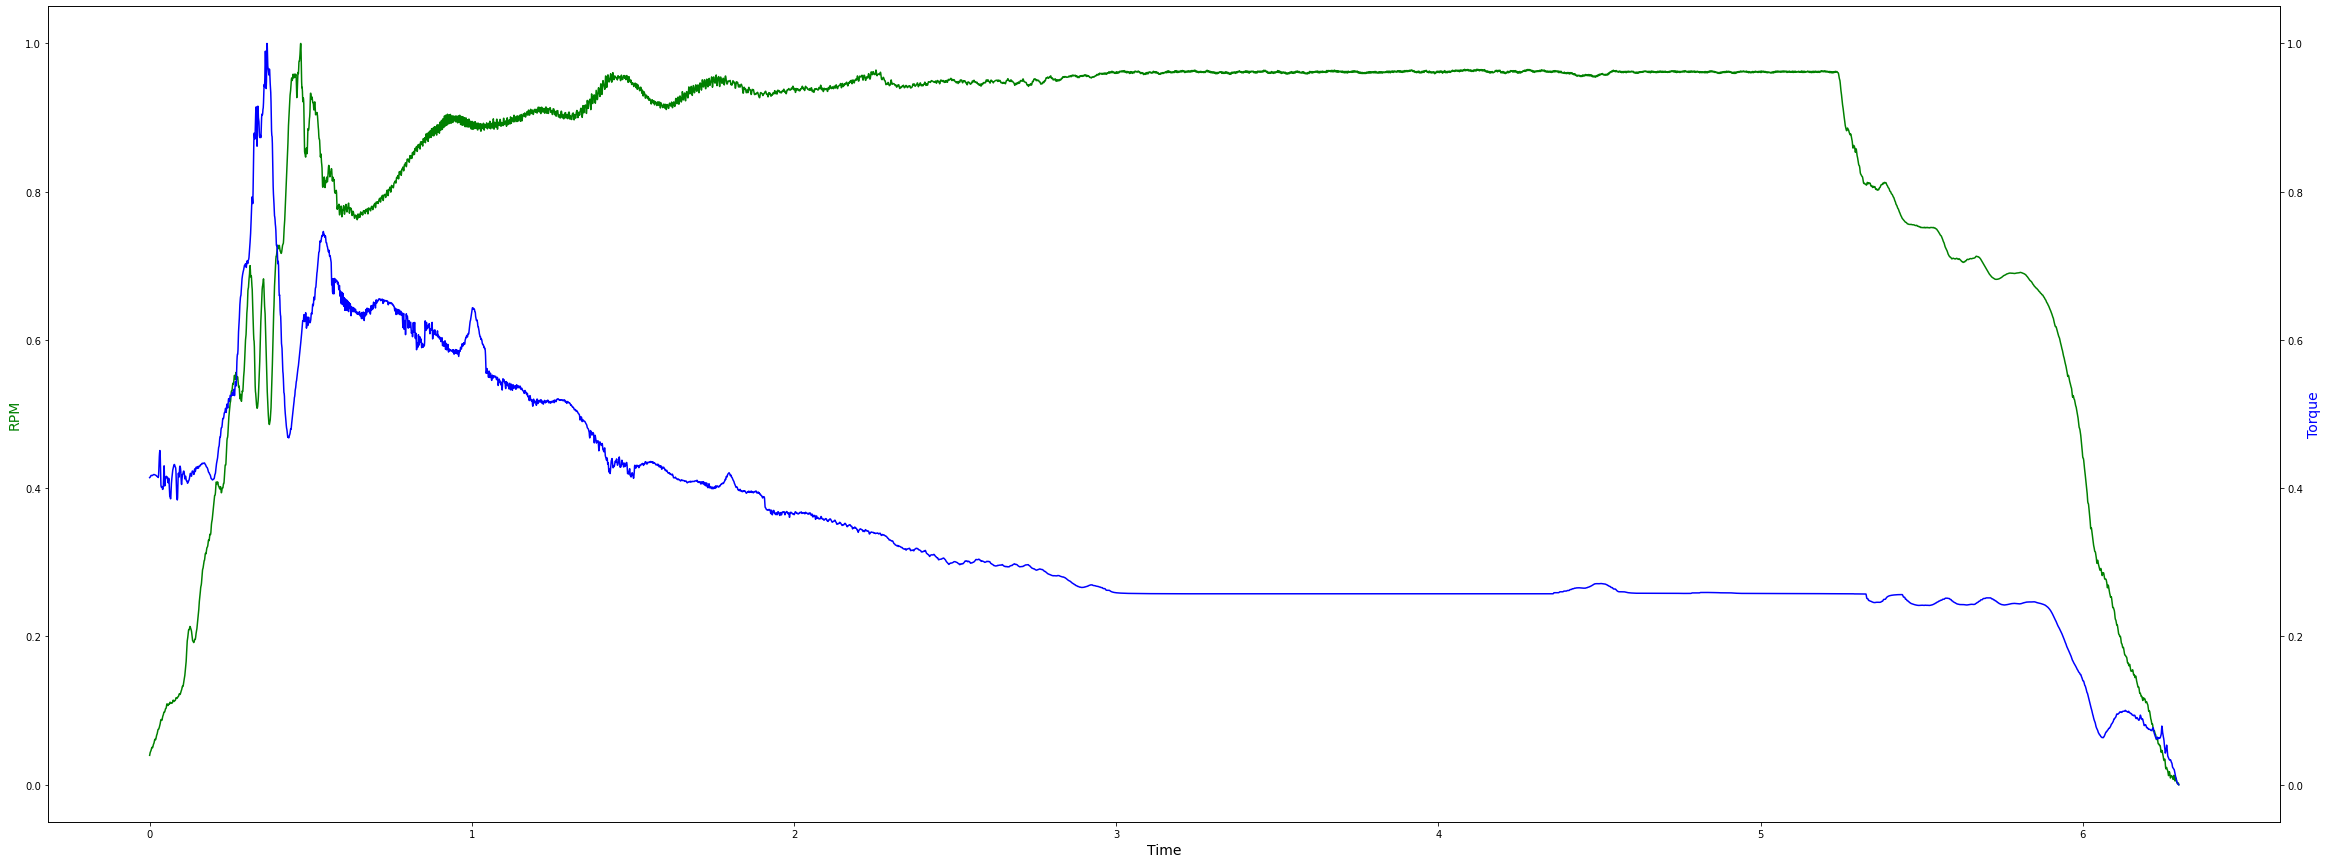

In [58]:
# create figure and axis objects with subplots()
fig,ax = plt.subplots(figsize = (40,15))
# make a plot
ax.plot(time,torque_raw_norm,color="green")
# set x-axis label
ax.set_xlabel("Time", fontsize = 14)
# set y-axis label
ax.set_ylabel("RPM",color="green",fontsize=14)

# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(time, rpm_raw_norm ,color="blue")
ax2.set_ylabel("Torque",color="blue",fontsize=14)
plt.show()

#### 2.3  Data Smoothening - Simple Moving Average Filter

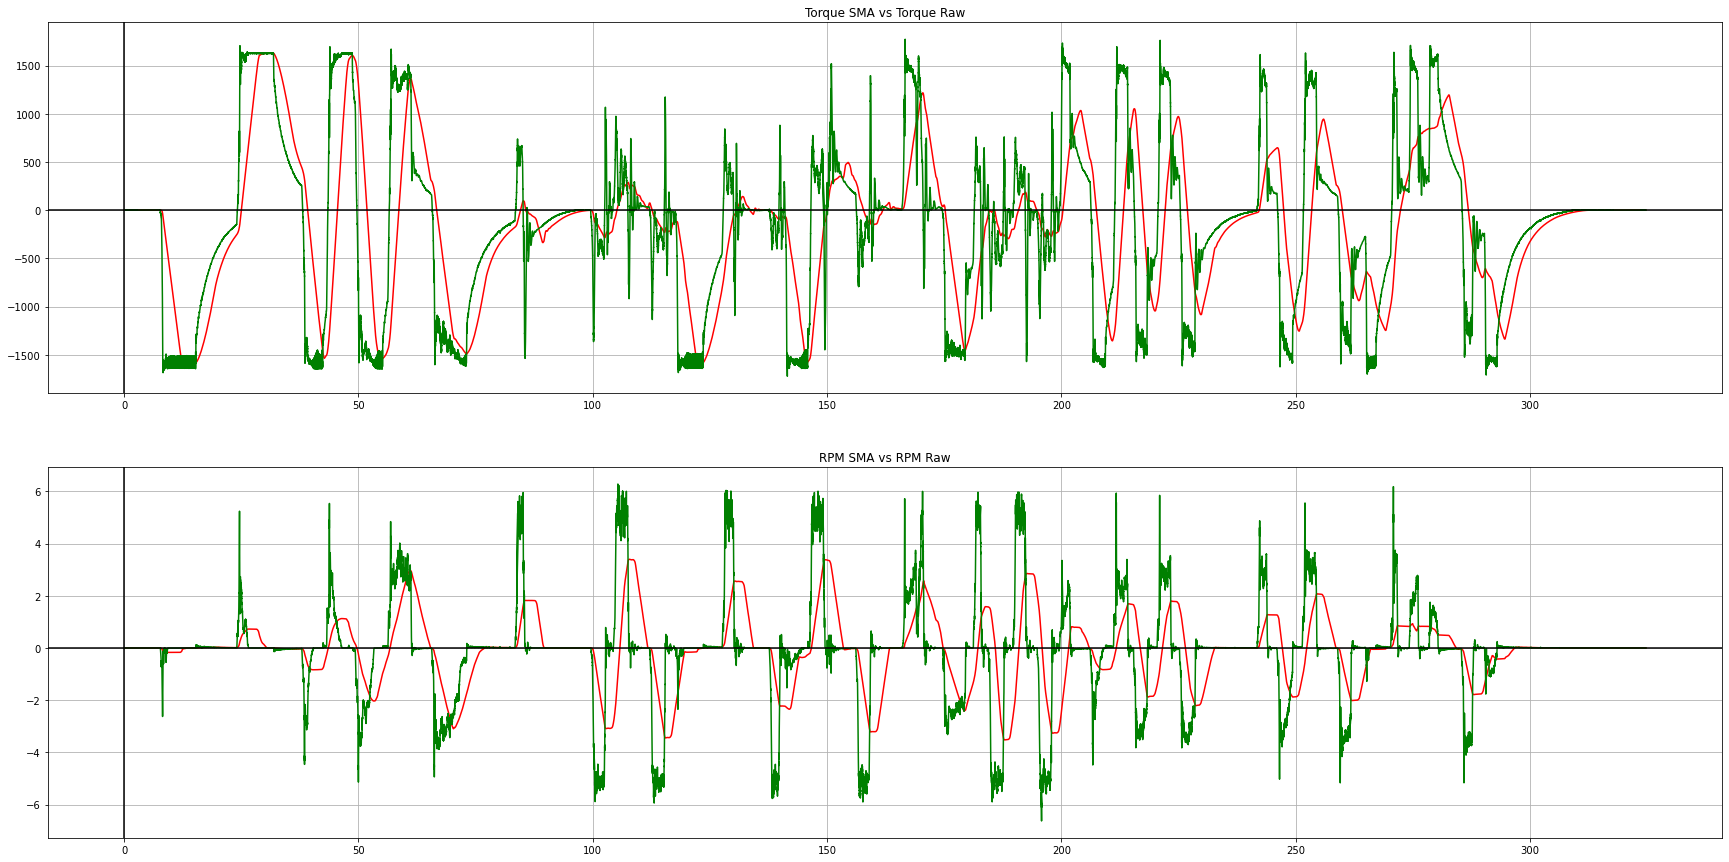

In [14]:
# torque and RPM smoothening using Simple Moving Average (SMA)

SMA_WIN_SIZE = 5000 #SMA window size

torque_SMA= torque_raw.rolling(SMA_WIN_SIZE, min_periods=1).mean()
rpm_SMA= rpm_raw.rolling(SMA_WIN_SIZE, min_periods=1).mean()


fig, ax = plt.subplots(2,1, figsize=(30, 15))
ax[0].plot(time, torque_SMA , 'r')
ax[0].plot(time, torque_raw , 'g')
ax[0].grid(True, which='both')
ax[0].axhline(y=0, color='k')
ax[0].axvline(x=0, color='k')
ax[0].title.set_text('Torque SMA vs Torque Raw')

ax[1].plot(time, rpm_SMA , 'r')
ax[1].plot(time, rpm_raw , 'g')
ax[1].grid(True, which='both')
ax[1].axhline(y=0, color='k')
ax[1].axvline(x=0, color='k')
ax[1].title.set_text('RPM SMA vs RPM Raw')



#### 2.4 Dataset Splitting 

 **2.4.1 Zero Crossing Detection** 

In [15]:
def zero_crossing_detection(data_frame):

    zero_crossing_index = np.array([0])
    
    for data_sample in range(0,data_frame.size) :
       
        if data_sample == data_frame.size-1 : 
            
            zero_crossing_index = np.delete(zero_crossing_index, 0)
            
            return zero_crossing_index
        
        if ((data_frame.iloc[data_sample] <= 0) and (data_frame.iloc[data_sample+1] >= 0)) or ((data_frame.iloc[data_sample] >= 0) and (data_frame.iloc[data_sample+1] <= 0)) : 
            
            zero_crossing_index = np.append(zero_crossing_index , data_sample)
            

In [16]:
torque_zero_crossing_index = zero_crossing_detection(torque_SMA)
rpm_zero_crossing_index = zero_crossing_detection(rpm_SMA)

print(torque_zero_crossing_index)
print(rpm_zero_crossing_index)

[  9423  30013  47008  54621  62179  70329  80027 101501 102835 126169
 135185 156837 160220 161403 161889 162176 164905 179990 189320 194243
 210236 222504 222824 229006 233702 240383 248952 255849 260841 266554
 272232 290629 296900 304063 311922 326815 344202 375040]
[  9273  18395  36898  52275  59583  68103  78468  92339 119549 126918
 134158 148361 161185 161715 162118 162607 163007 163493 164111 175990
 184178 196046 196325 197227 197357 198429 198436 199303 209717 218611
 223073 229104 235032 241831 247120 254033 260179 265834 271752 279203
 296551 302782 310315 323219 341108 356046 376262]


**2.4.2 Dataset Splitting**

**2.4.2 Dataset Splitting (Set1)**

In [147]:
#split data (only extracted the first data set)

correction_factor = 2500 # temporary solution to compensate for the shift during SMA filter
#split_index_1 = torque_zero_crossing_index[1]
#split_index_2 = torque_zero_crossing_index[2]
split_index_1 = torque_zero_crossing_index[1] - correction_factor
split_index_2 = torque_zero_crossing_index[2] - correction_factor
df_raw_1 = df_raw.iloc[split_index_1:split_index_2, :]

df_raw_1.head()


,Zeit -,n_sprocket_left - U/min,x_sprocket_left - mm,torque_travel_left - Nm,torque_travel_right - Nm,p_track_tension_left - bar,p_track_tension_right - bar
27513,22.927500,0.007126,-47.399404,-197.637814,304.914518,121.411255,60.817841
27514,22.928333,0.007355,-47.398846,-197.761213,304.832692,121.418480,60.823391
27515,22.929167,0.008133,-47.398250,-197.443759,305.065635,121.429901,60.838055
27516,22.930000,0.009048,-47.397588,-196.973735,305.243639,121.436844,60.845558
27517,22.930833,0.009688,-47.396866,-196.813817,305.077163,121.441742,60.837399


Text(0.5, 0.98, 'First part')

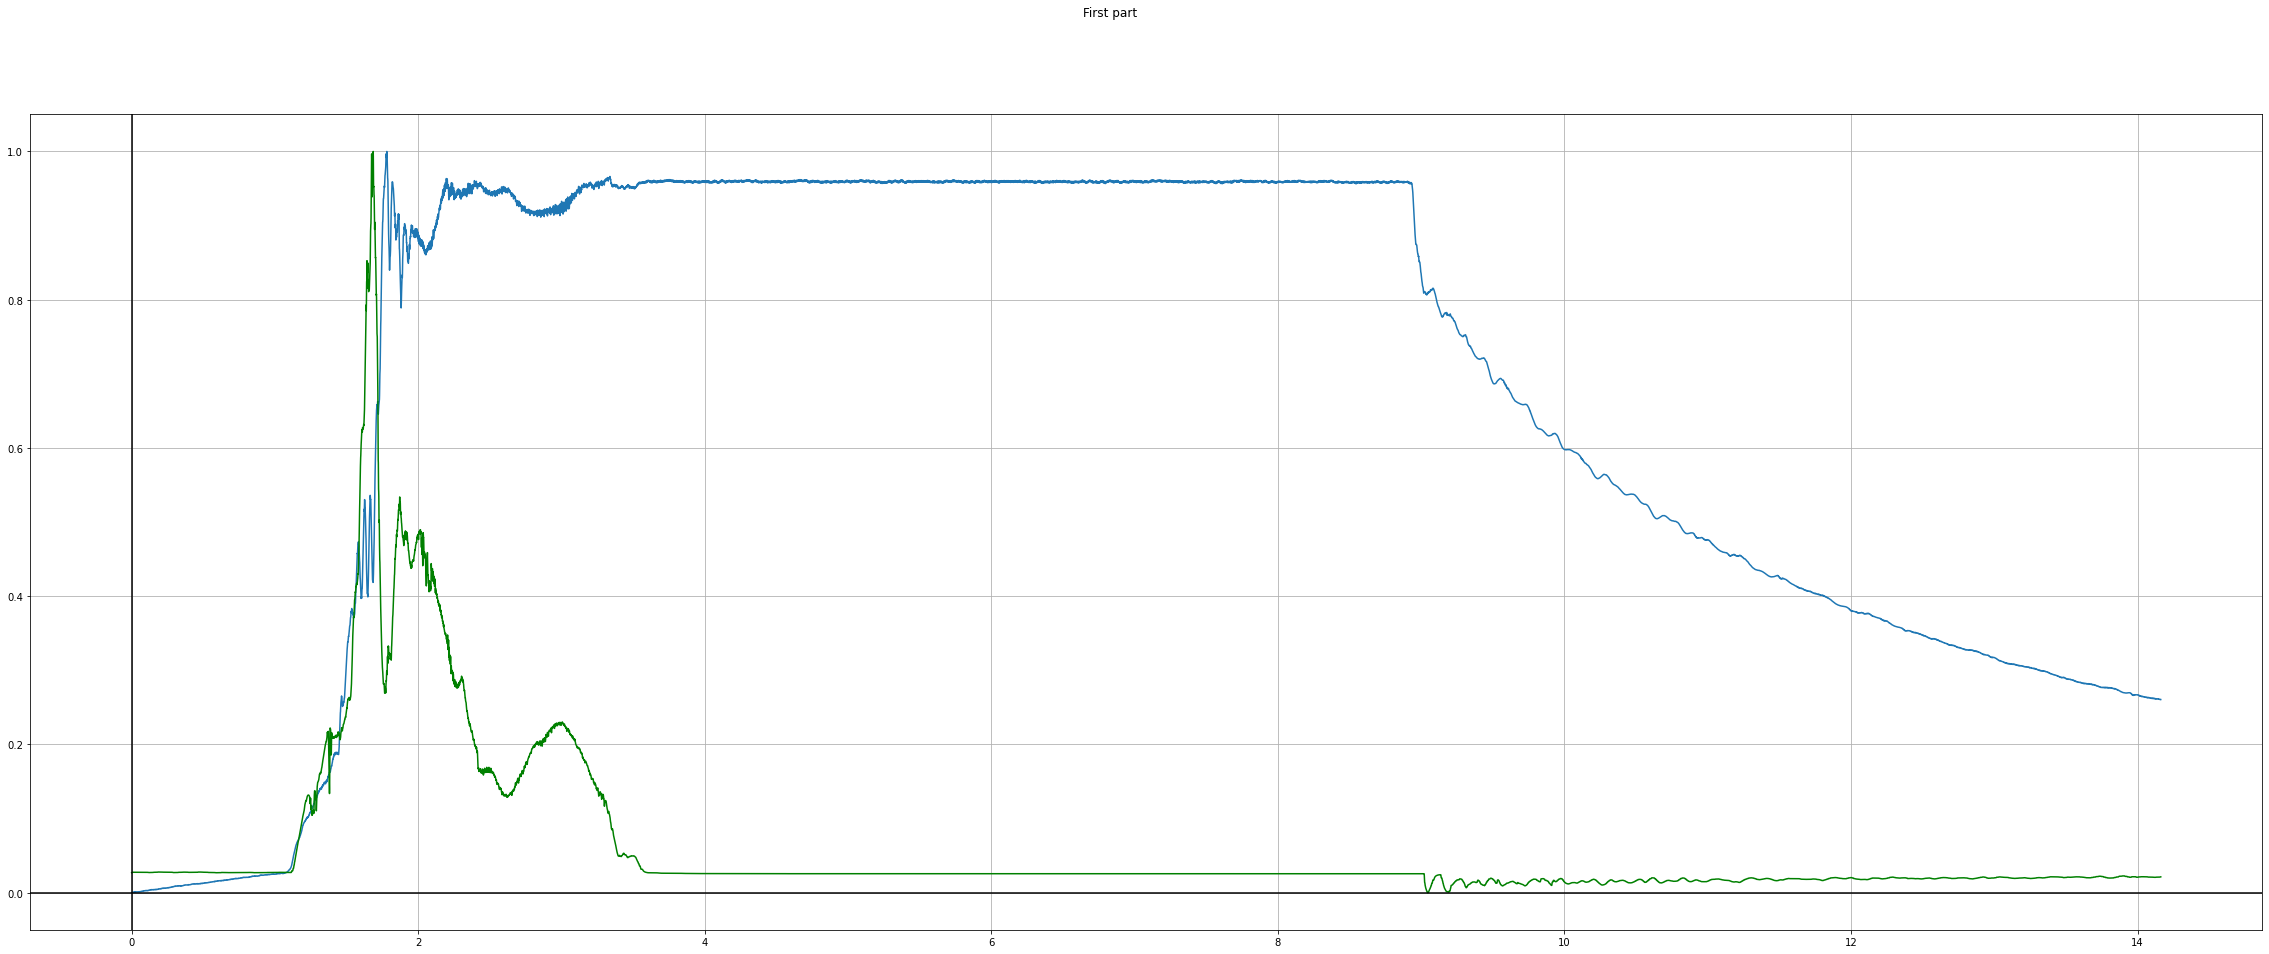

In [148]:
# Plot normalized data
rpm_raw = df_raw_1["n_sprocket_left - U/min"]
torque_raw = df_raw_1["torque_travel_left - Nm"]
time = df_raw_1["Zeit - "] - df_raw_1["Zeit - "].min() #to compensate for the time shift while splitting

torque_raw_norm = (torque_raw-torque_raw.min())/(torque_raw.max()-torque_raw.min())
rpm_raw_norm = (rpm_raw-rpm_raw.min())/(rpm_raw.max()-rpm_raw.min())

fig, ax = plt.subplots(1,1, figsize = (40,15))
ax.plot(time, torque_raw_norm )
ax.plot(time, rpm_raw_norm , 'g' )
ax.grid(True, which='both')
ax.axhline(y=0, color='k')
ax.axvline(x=0, color='k')
fig.suptitle("First part")


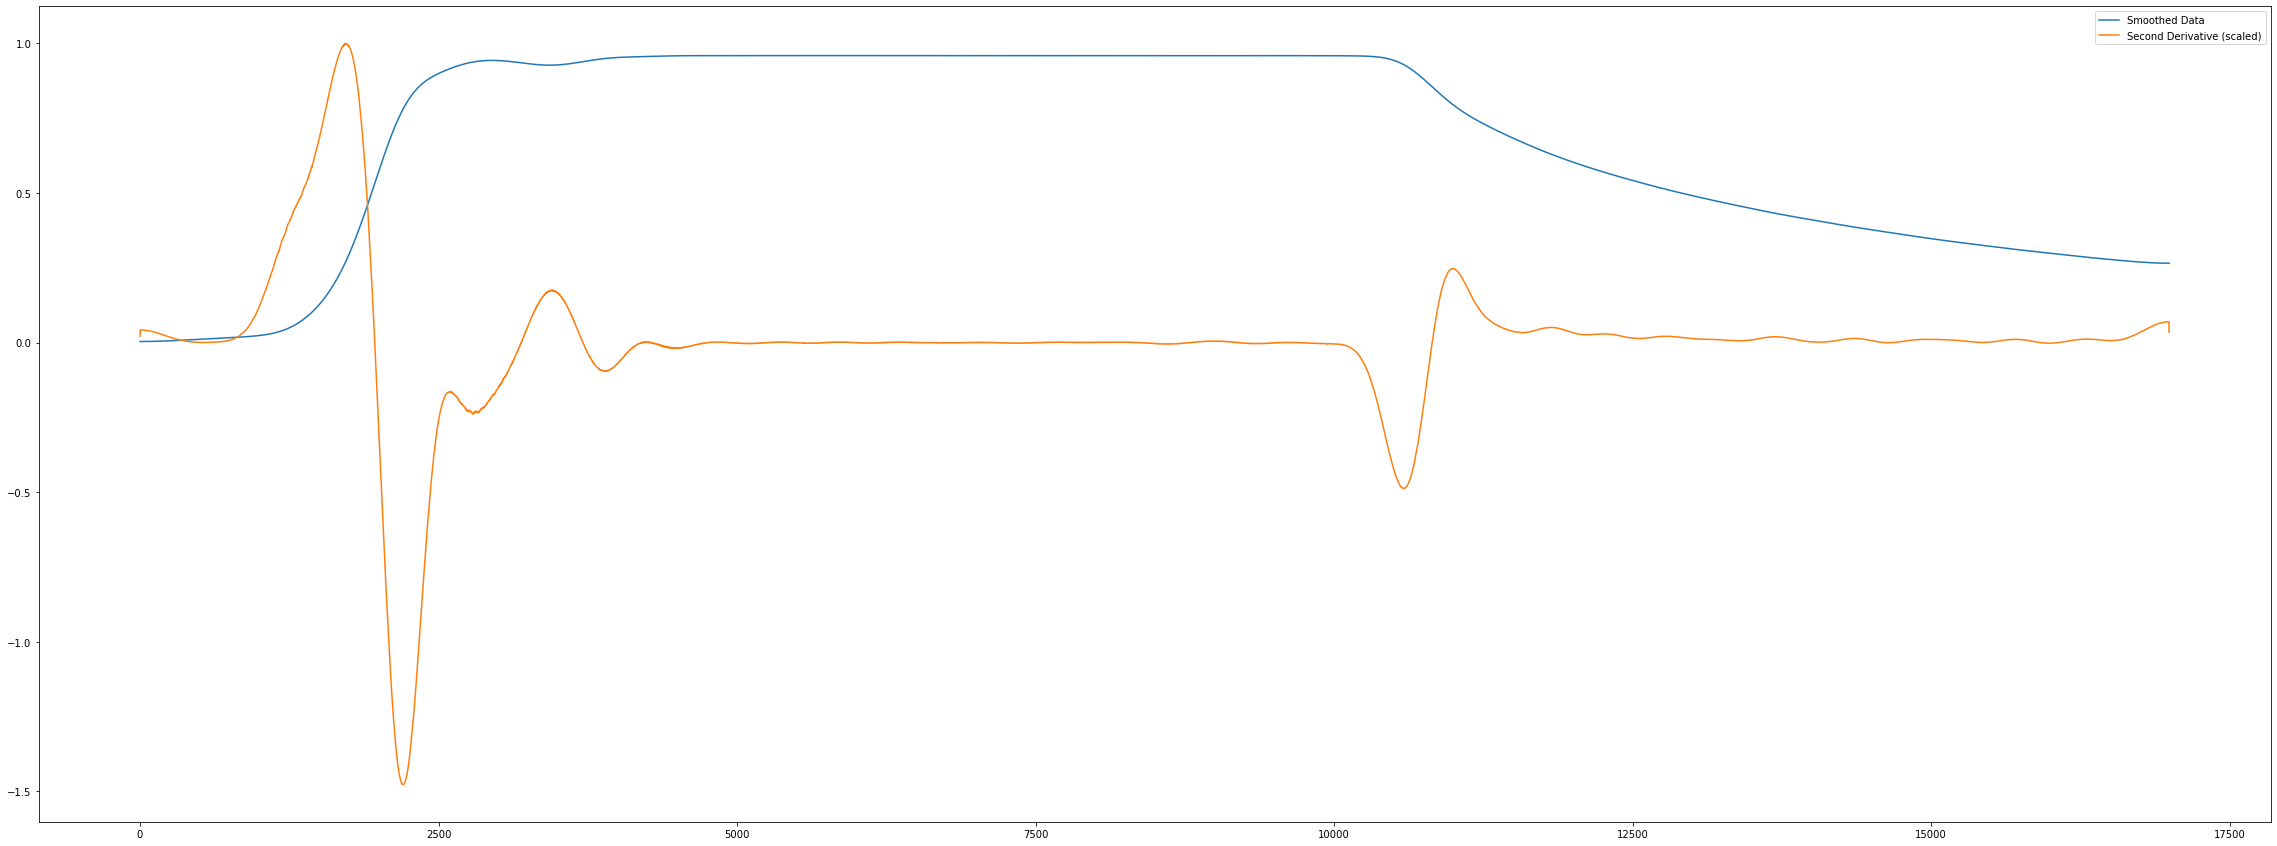

In [149]:
#first data set # derivative torque
x = time
y = torque_raw_norm

# smooth gausian
smooth = gaussian_filter1d(y, 200)

# compute second derivative
smooth_d2 = np.gradient(np.gradient(smooth))

# find switching points
#infls = np.where(np.diff(np.sign(smooth_d2)))[0]

# plot results
plt.figure(figsize = (40,15))
#plt.plot(y, label='Noisy Data') #original data
plt.plot(smooth, label='Smoothed Data') #after gausian
plt.plot(smooth_d2 / np.max(smooth_d2), label='Second Derivative (scaled)') #second derivative
plt.legend()

#for i, infl in enumerate(infls, 1):
#    plt.axvline(x=infl, color='k', label=f'Inflection Point {i}')
#plt.legend(bbox_to_anchor=(1.55, 1.0))

[ 153  363  511  709  876 1089 1149 1157 1162 1167 1341 1537 1842 2124
 2341 2344 2690 2915 3145 3149 3453 3455 3868 4078 4306 4450 4667 4997]


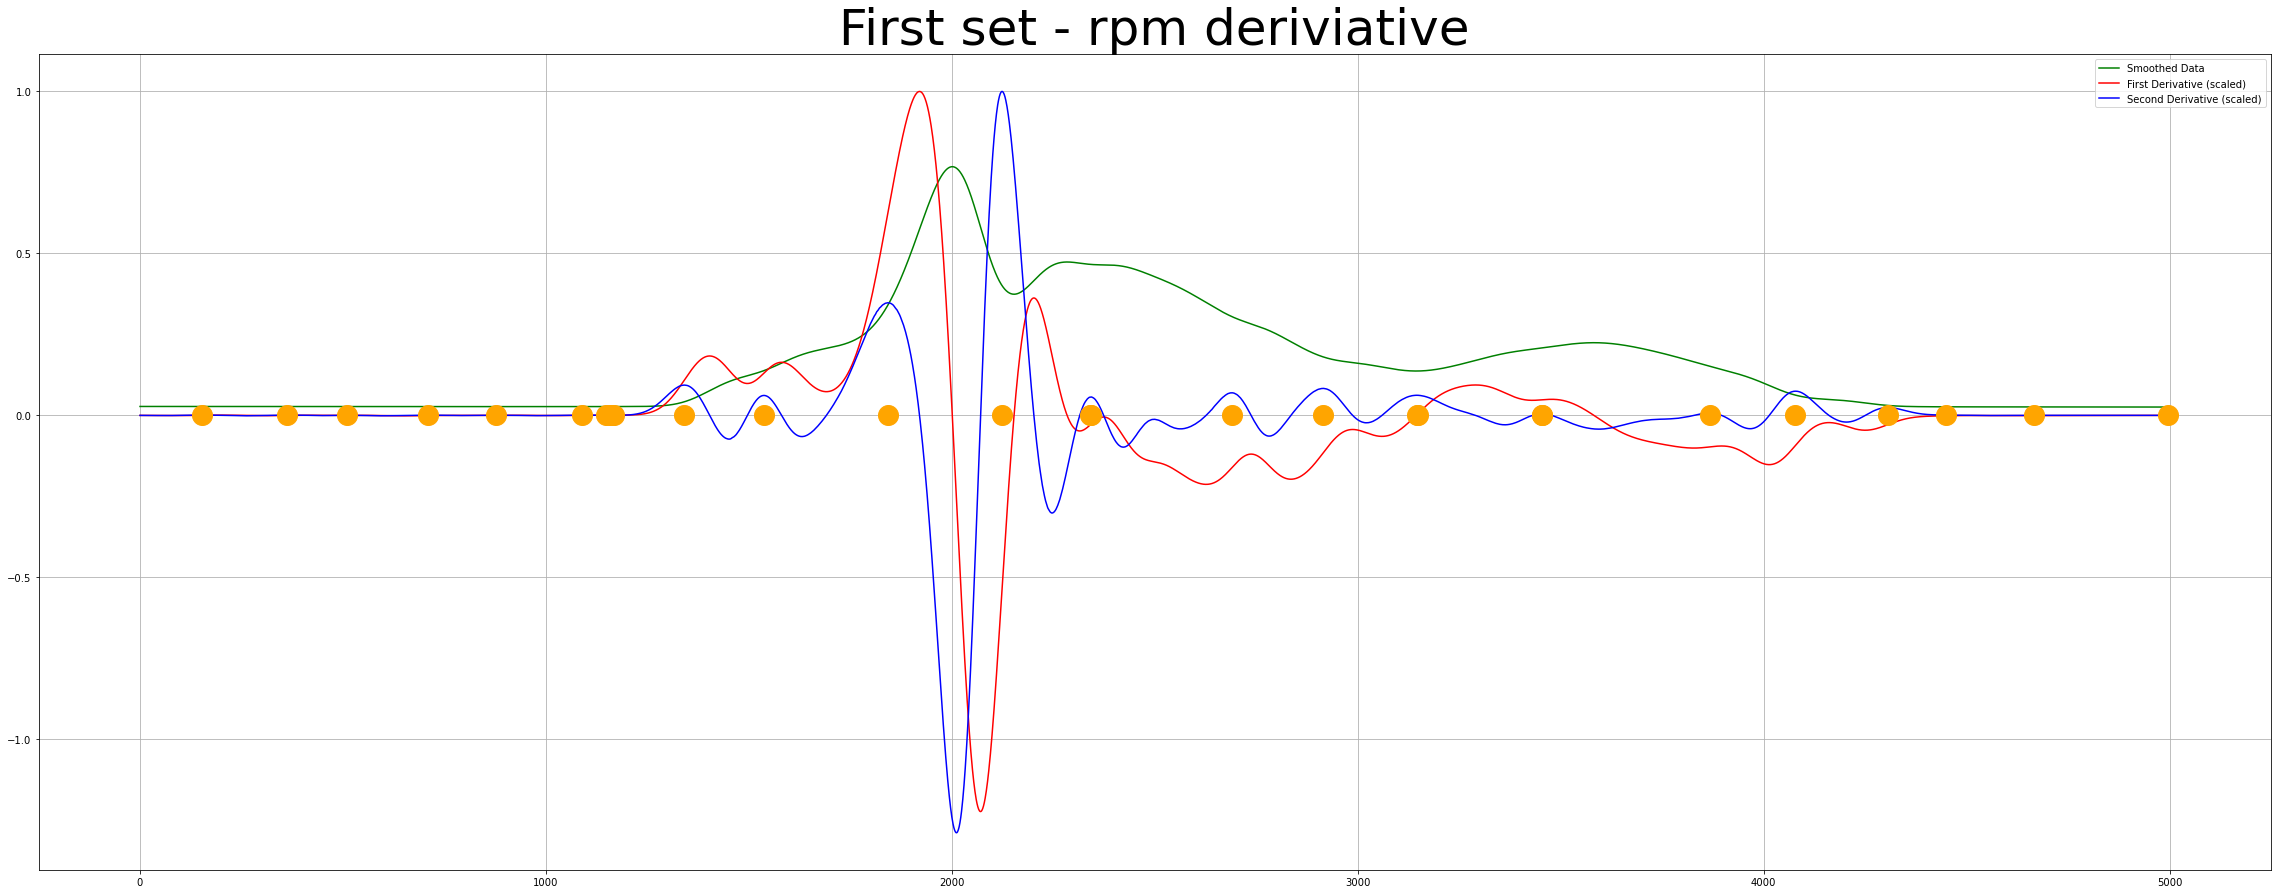

In [176]:
#first data set # derivative rpm
x = time[0:5000]
y = rpm_raw_norm[0:5000]

# smooth gausian
smooth = gaussian_filter1d(y, 50)

# compute second derivative
smooth_d1 = np.gradient(smooth)
smooth_d2 = np.gradient(np.gradient(smooth))

# for local maxima
max = argrelextrema(smooth_d1, np.greater)

# find switching points
#infls = np.where(np.diff(np.sign(smooth_d2)))[0]

# plot results
plt.figure(figsize = (40,15))
#plt.plot(y, label='Noisy Data') #original data
plt.plot(smooth, label='Smoothed Data',color='g') #after gausian
plt.plot(smooth_d1 / np.max(smooth_d1), label='First Derivative (scaled)',color='r') #first derivative
plt.plot(smooth_d2 / np.max(smooth_d2), label='Second Derivative (scaled)',color='b') #second derivative

#local maxima for first derivative
#plt.plot(1500,smooth_d1[94],marker="o",markersize=20)
peaks, _ = find_peaks((smooth_d2 / np.max(smooth_d2)), height=0)
print(peaks)
#plt.plot(smooth_d1)
plt.plot(peaks, smooth_d2[peaks], "o",markersize=20,color="orange")

plt.title("First set - rpm deriviative",fontsize=50)
plt.grid()
plt.legend()

[  94 1773 3351]


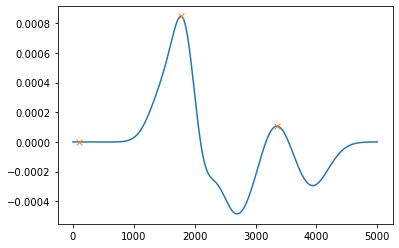

In [158]:
#get local minima and maxnima
import numpy as np
from scipy.signal import argrelextrema
from scipy.signal import find_peaks

#x = np.random.random(12)

# for local maxima
#max = argrelextrema(smooth_d1, np.greater)
#print(max)
#print(smooth_d1[94])
peaks, _ = find_peaks(smooth_d1, height=0)
print(peaks)
plt.plot(smooth_d1)
plt.plot(peaks, smooth_d1[peaks], "x")




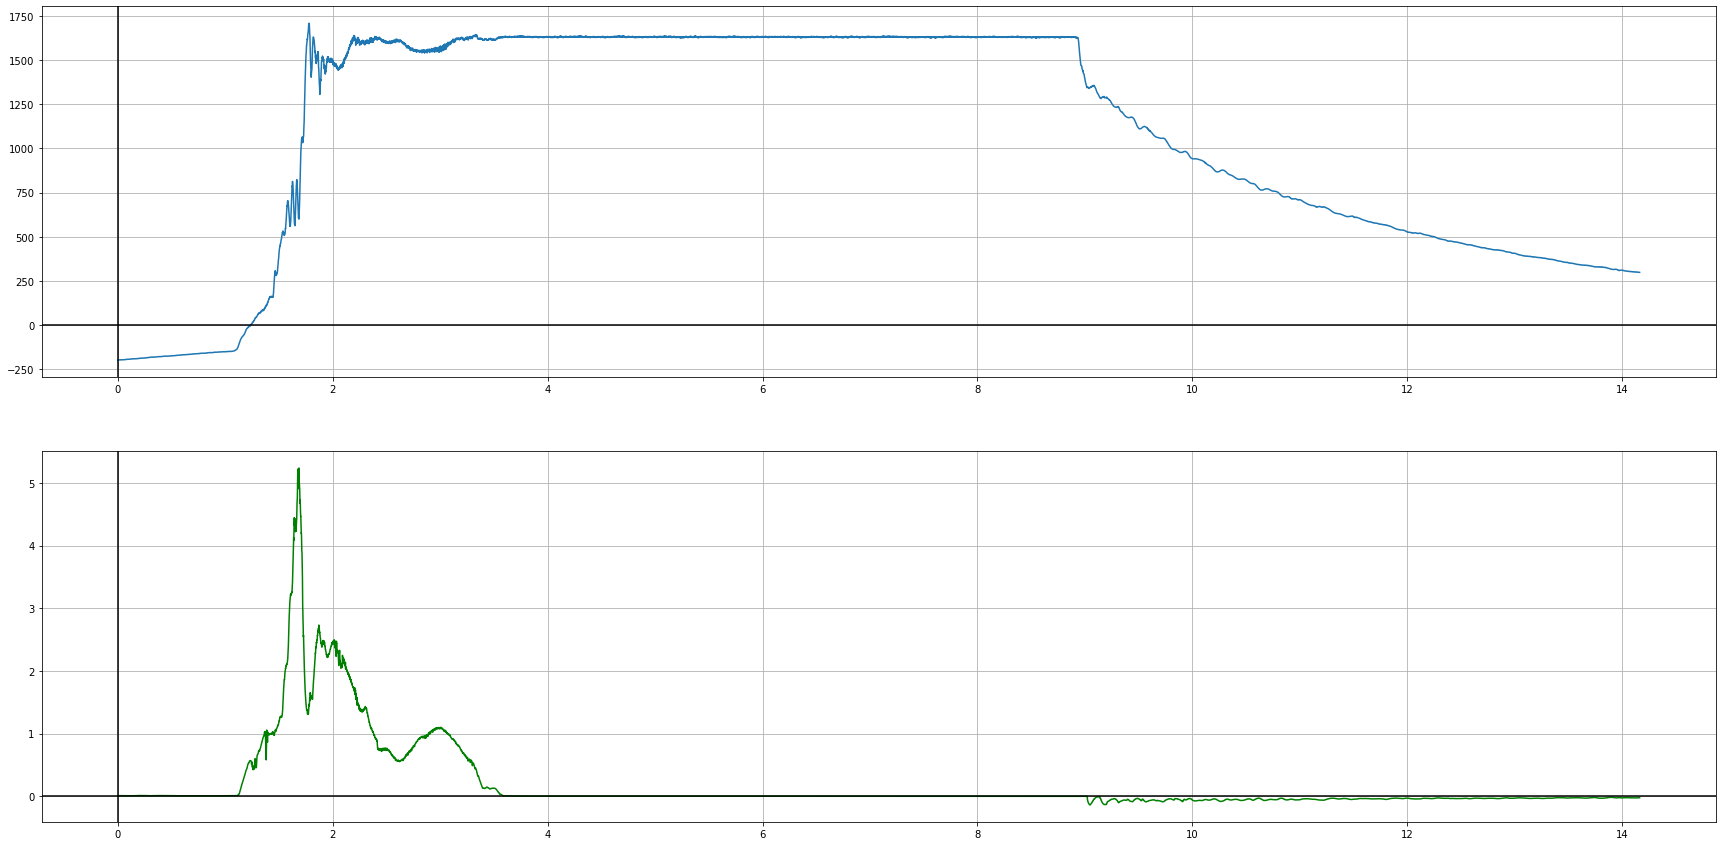

In [19]:
fig, ax = plt.subplots(2,1, figsize = (30,15))
ax[0].plot(time, torque_raw )
ax[0].grid(True, which='both')
ax[0].axhline(y=0, color='k')
ax[0].axvline(x=0, color='k')

ax[1].plot(time, rpm_raw , 'g')
ax[1].grid(True, which='both')
ax[1].axhline(y=0, color='k')
ax[1].axvline(x=0, color='k')

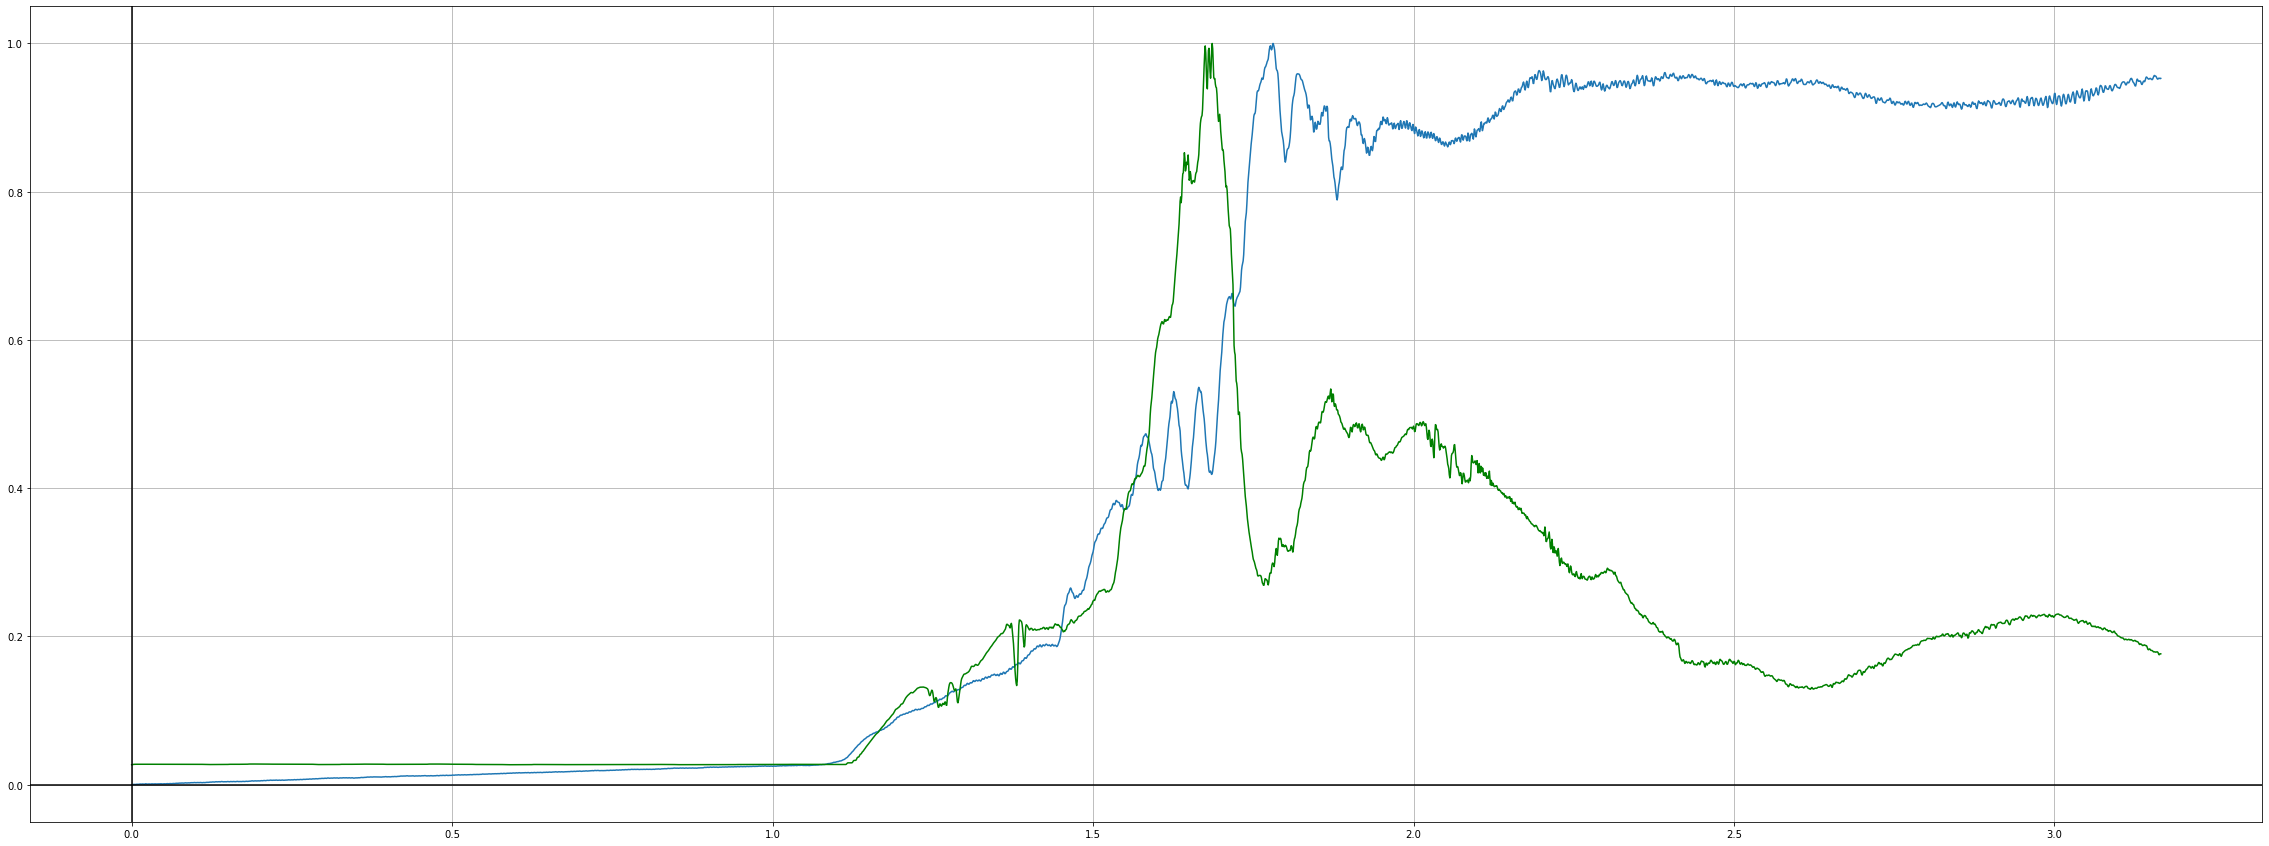

In [60]:
#closer look
#torque_raw_norm = (torque_raw-torque_raw.min())/(torque_raw.max()-torque_raw.min())
#rpm_raw_norm = (rpm_raw-rpm_raw.min())/(rpm_raw.max()-rpm_raw.min())

fig, ax = plt.subplots(1,1, figsize = (40,15))
ax.plot(time[0:3800], torque_raw_norm[0:3800] )
ax.plot(time[0:3800], rpm_raw_norm[0:3800] , 'g' )
ax.grid(True, which='both')
ax.axhline(y=0, color='k')
ax.axvline(x=0, color='k')


**2.4.2 Dataset Splitting (Set2)**

In [39]:
split_index_3 = torque_zero_crossing_index[3] - correction_factor
split_index_4 = torque_zero_crossing_index[4] - correction_factor
df_raw_2 = df_raw.iloc[split_index_3:split_index_4, :]

df_raw_2.head()

,Zeit -,n_sprocket_left - U/min,x_sprocket_left - mm,torque_travel_left - Nm,torque_travel_right - Nm,p_track_tension_left - bar,p_track_tension_right - bar
52121,43.434167,1.169058,-82.551983,-63.255082,85.094573,139.372116,82.380608
52122,43.435000,1.171849,-82.461792,-59.553627,83.609202,139.010574,82.485588
52123,43.435833,1.175006,-82.371372,-56.258329,82.679232,138.637390,82.585693
52124,43.436667,1.180543,-82.280617,-54.247851,79.443582,138.262909,82.672104
52125,43.437500,1.186399,-82.189423,-52.967535,73.932404,137.905472,82.750862


Text(0.5, 0.98, 'Second part')

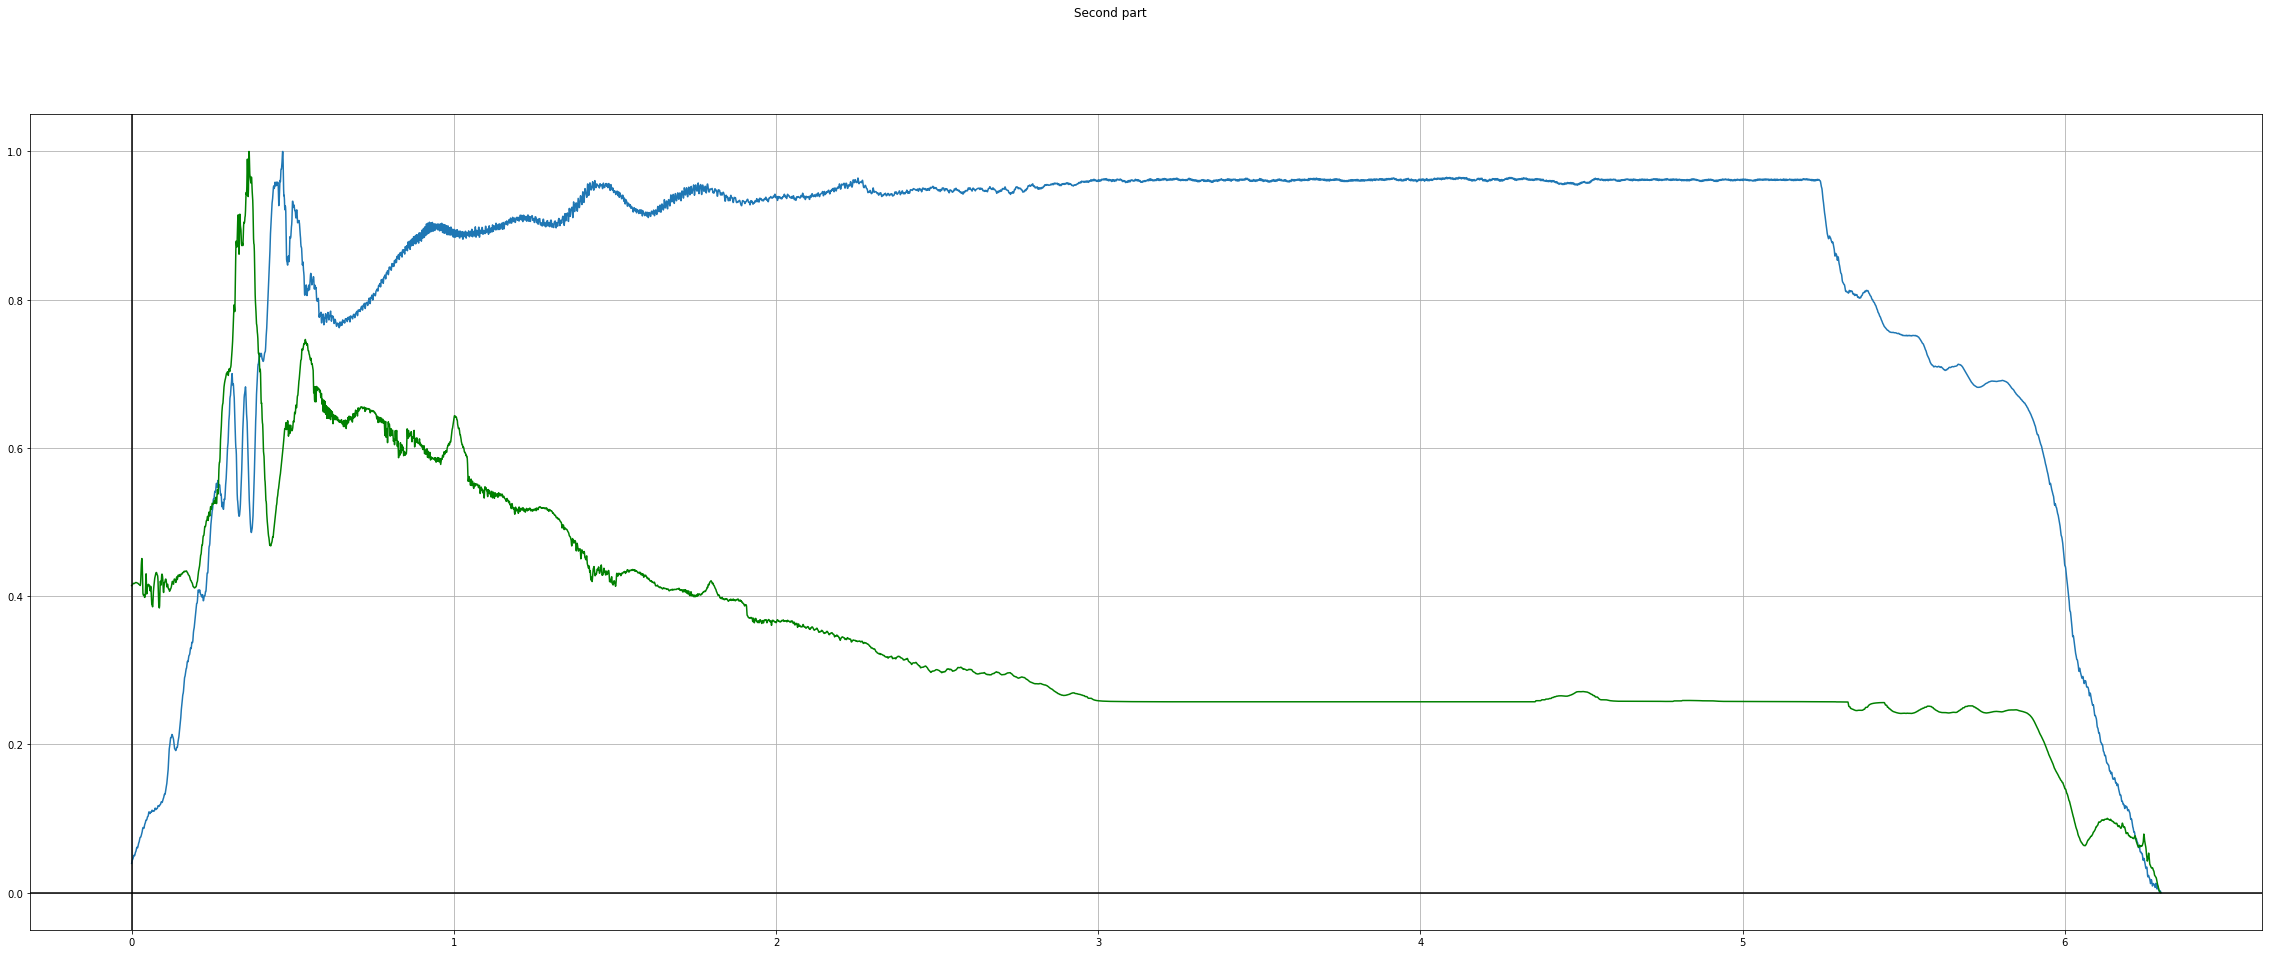

In [48]:
# Plot normalized data
rpm_raw = df_raw_2["n_sprocket_left - U/min"]
torque_raw = df_raw_2["torque_travel_left - Nm"]
time = df_raw_2["Zeit - "] - df_raw_2["Zeit - "].min() #to compensate for the time shift while splitting

torque_raw_norm = (torque_raw-torque_raw.min())/(torque_raw.max()-torque_raw.min())
rpm_raw_norm = (rpm_raw-rpm_raw.min())/(rpm_raw.max()-rpm_raw.min())

fig, ax = plt.subplots(1,1, figsize = (40,15))
ax.plot(time, torque_raw_norm )
ax.plot(time, rpm_raw_norm , 'g' )
ax.grid(True, which='both')
ax.axhline(y=0, color='k')
ax.axvline(x=0, color='k')
fig.suptitle("Second part")


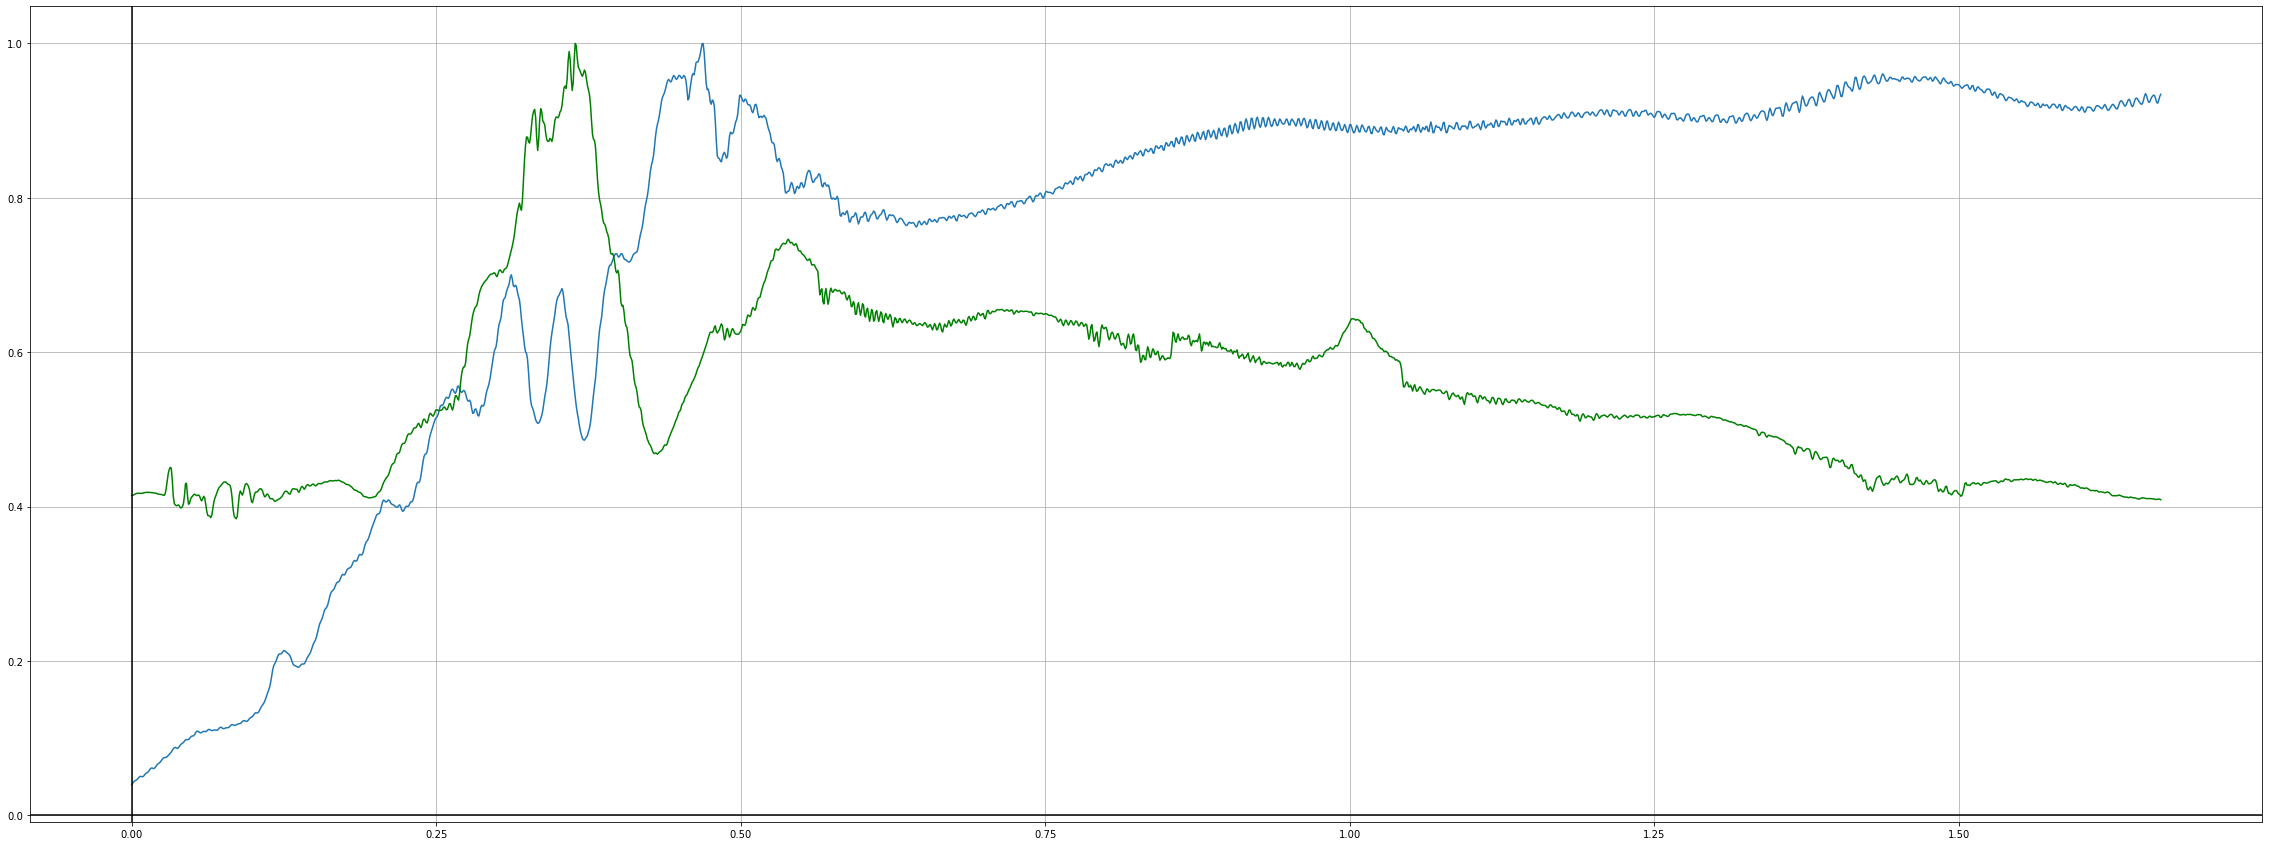

In [51]:
#closer look
#torque_raw_norm = (torque_raw-torque_raw.min())/(torque_raw.max()-torque_raw.min())
#rpm_raw_norm = (rpm_raw-rpm_raw.min())/(rpm_raw.max()-rpm_raw.min())

fig, ax = plt.subplots(1,1, figsize = (40,15))
ax.plot(time[0:2000], torque_raw_norm[0:2000] )
ax.plot(time[0:2000], rpm_raw_norm[0:2000] , 'g' )
ax.grid(True, which='both')
ax.axhline(y=0, color='k')
ax.axvline(x=0, color='k')

### testing for derivative function

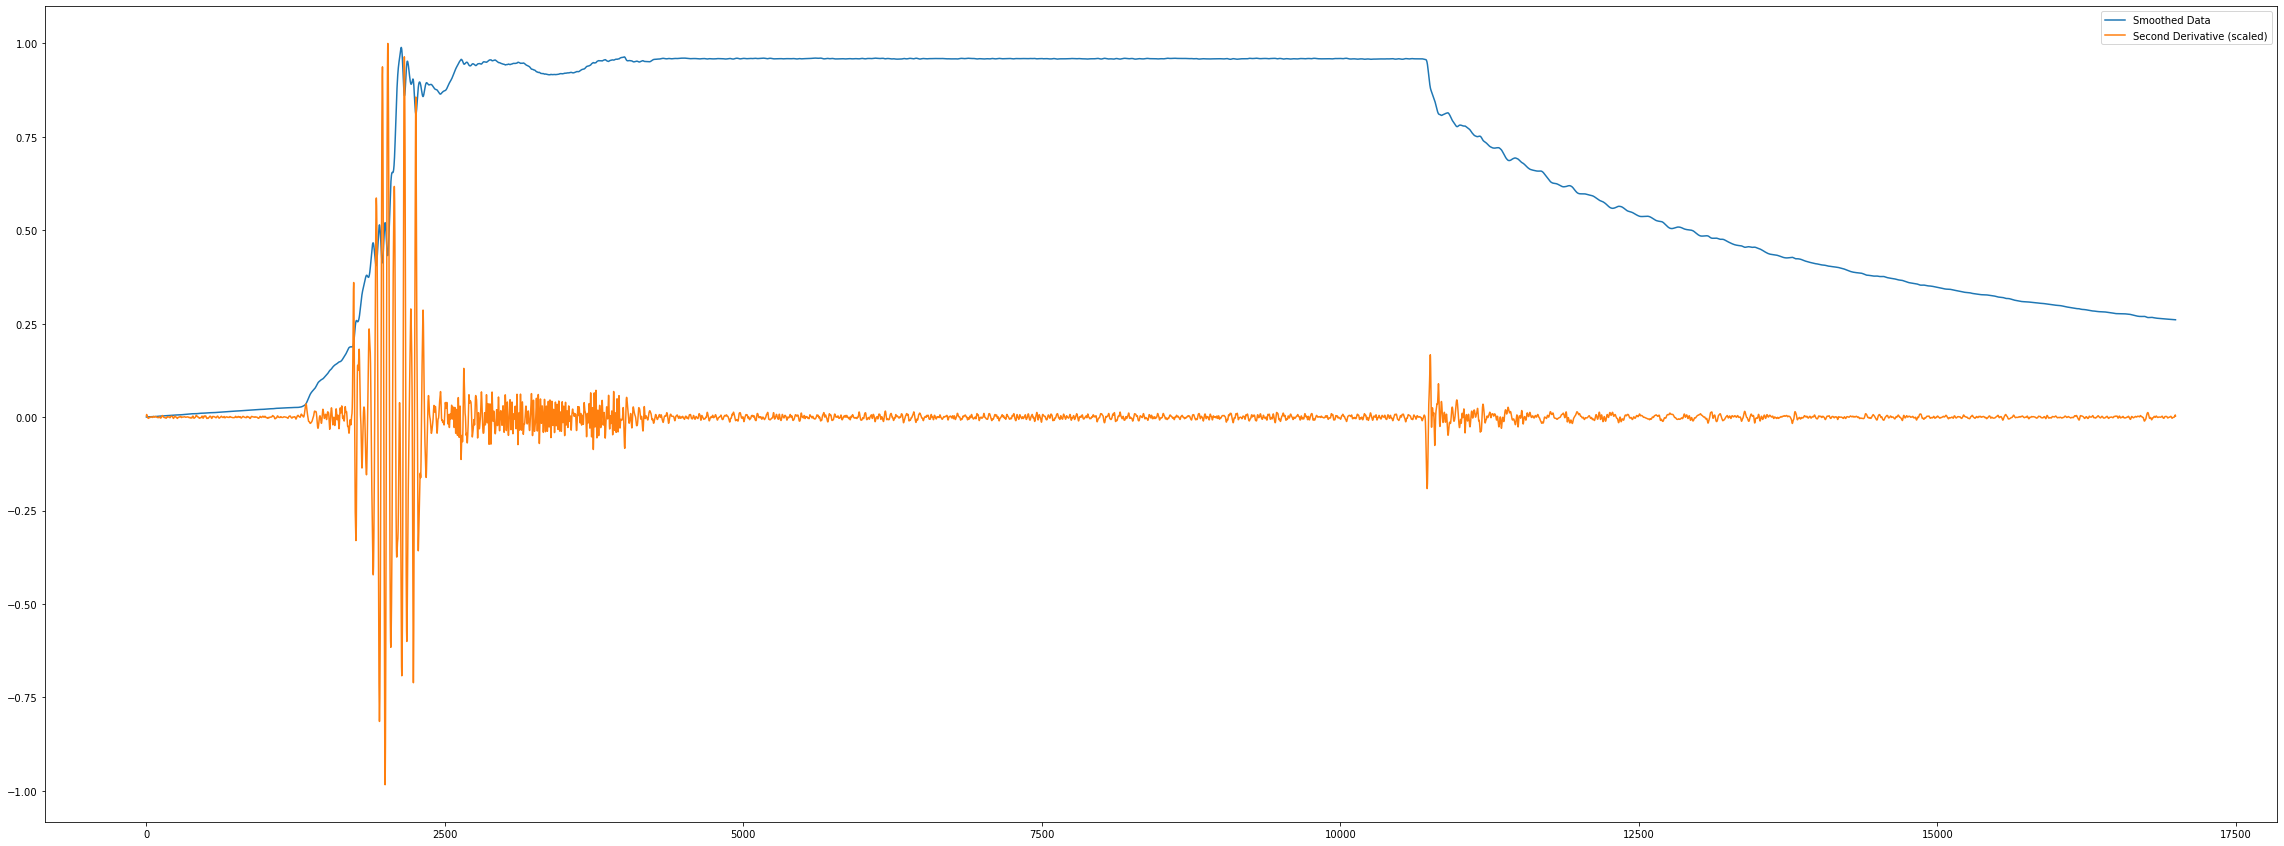

In [85]:
#first data set
x = time
y = torque_raw_norm

# smooth
smooth = gaussian_filter1d(y, 5)

# compute second derivative
smooth_d2 = np.gradient(np.gradient(smooth))

# find switching points
#infls = np.where(np.diff(np.sign(smooth_d2)))[0]

# plot results
#plt.plot(y, label='Noisy Data')
plt.figure(figsize = (40,15))
plt.plot(smooth, label='Smoothed Data')
plt.plot(smooth_d2 / np.max(smooth_d2), label='Second Derivative (scaled)')
plt.legend()

#for i, infl in enumerate(infls, 1):
#    plt.axvline(x=infl, color='k', label=f'Inflection Point {i}')
#plt.legend(bbox_to_anchor=(1.55, 1.0))

In [78]:
#derivate function
x = time
y = torque_raw_norm

def derivative(x,y):
    yprime = np.diff(y)/np.diff(x)
    xprime = []
    for i in range(len(yprime)):
        xtemp = (x[i+1]+x[i])/2
        xprime = np.append(xprime,xtemp)
    return xprime,yprime

xprime, yprime = derivative(x,y)
plt.plot(xprime,yprime, label="1st derivative")


KeyError: 1